> Try to divide train and test(GNAR fivenet)

- 시각화 정리
- iterable하기 가능하게 class로
- 혹은 for문으로
- loss
- mse


나중에는 노드별 trasfom



In [1]:
def vis(STdata):
    N = STdata.shape[1]
    fig, ax = plt.subplots(5,1,(15,5))
    for n in range(N):
        ax[n].plot(fiveVTS[:,0])
    #fig.set_width()
    fig.set_height(N*5) 
    return fig 

# import

In [2]:
import rpy2
import rpy2.robjects as ro 
from rpy2.robjects.vectors import FloatVector 
from rpy2.robjects.packages import importr

import torch
import numpy as np
from tqdm import tqdm

import torch.nn.functional as F
from torch_geometric_temporal.nn.recurrent import GConvGRU

import matplotlib.pyplot as plt
import pandas as pd

import time

from scipy.interpolate import interp1d

In [3]:
class RecurrentGCN(torch.nn.Module):
    def __init__(self, node_features, filters):
        super(RecurrentGCN, self).__init__()
        self.recurrent = GConvGRU(node_features, filters, 2)
        self.linear = torch.nn.Linear(filters, 1)

    def forward(self, x, edge_index, edge_weight):
        h = self.recurrent(x, edge_index, edge_weight)
        h = F.relu(h)
        h = self.linear(h)
        return h

# R

In [6]:
%load_ext rpy2.ipython

In [8]:
%%R
library(GNAR)
library(igraph)

# Data

In [9]:
%%R
edges <- as.matrix(fiveNet)
data("fiveNode")

In [10]:
%R -o fiveVTS
%R -o edges

- node: 5
- time 200

# functions 

In [11]:
def vis(spatiotemporaldata):
    N = spatiotemporaldata.shape[1]
    fig, ax = plt.subplots(N,1)
    for n in range(N):
        ax[n].plot(spatiotemporaldata[:,n])
        ax[n].set_title('node='+str(n))
    #fig.set_width()
    fig.set_figheight(N*2) 
    fig.tight_layout()
    return fig 

In [12]:
def vis2(spatiotemporaldata1,spatiotemporaldata2):
    N = spatiotemporaldata1.shape[1]
    fig, ax = plt.subplots(N,1)
    for n in range(N):
        ax[n].plot(spatiotemporaldata1[:,n],label='data1')
        ax[n].plot(spatiotemporaldata2[:,n],label='data2')
        ax[n].set_title('node='+str(n))
        ax[n].legend()
    #fig.set_width()
    fig.set_figheight(N*2) 
    fig.tight_layout()
    return fig 

In [13]:
edges_tensor = torch.tensor(edges)

In [14]:
nonzero_indices = edges_tensor.nonzero()

In [15]:
fiveNet_edge = np.array(nonzero_indices).T

In [16]:
T = 200
N = 5 # number of Nodes
E = fiveNet_edge
V = np.array([1,2,3,4,5])
t = np.arange(0,T)
node_features = 1

In [17]:
edge_index = torch.tensor(E)
edge_attr = torch.tensor(np.array([1,1,1,1,1,1,1,1,1,1]),dtype=torch.float32)

In [18]:
fiveVTS.shape

(200, 5)

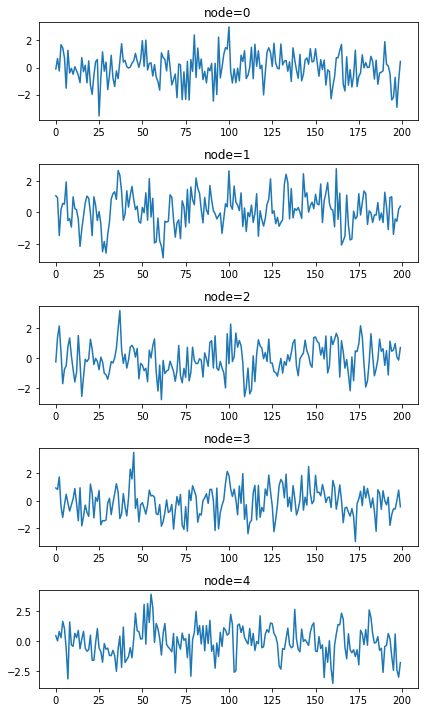

In [19]:
vis(fiveVTS);

In [20]:
fiveVTS_train = fiveVTS[:int(len(fiveVTS)*0.8)]
fiveVTS_test = fiveVTS[int(len(fiveVTS)*0.8):]

In [21]:
fiveVTS_train.shape, fiveVTS_test.shape

((160, 5), (40, 5))

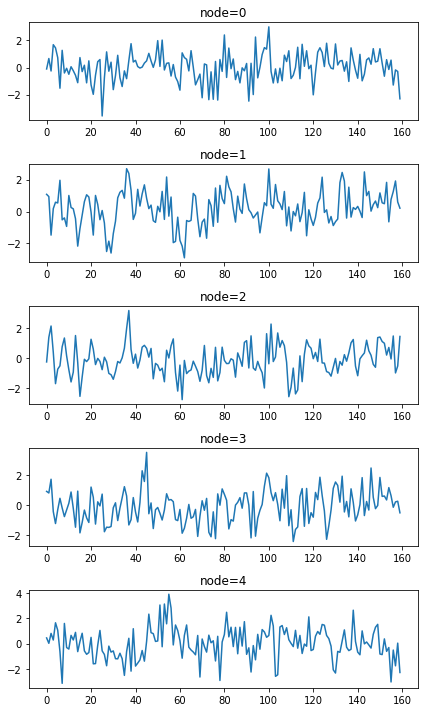

In [22]:
vis(fiveVTS_train);

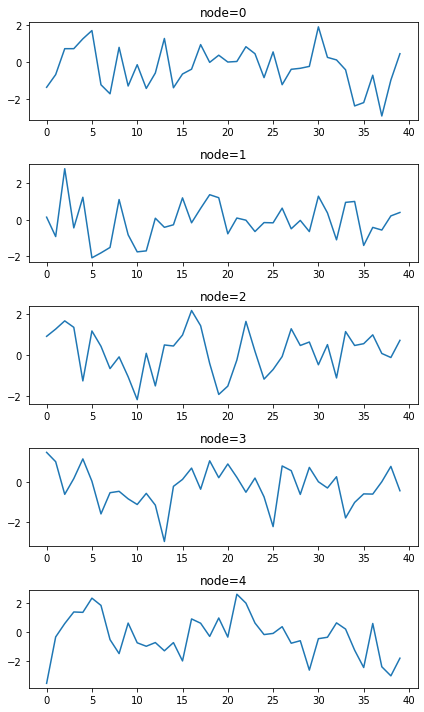

In [23]:
vis(fiveVTS_test);

# Randomly Missing Values

In [24]:
np.random.seed(1)
seed_number1 = np.random.choice(160,80,replace=False)

In [25]:
np.random.seed(3)
seed_number2 = np.random.choice(160,80,replace=False)

In [26]:
np.random.seed(5)
seed_number3 = np.random.choice(160,80,replace=False)

In [27]:
np.random.seed(7)
seed_number4 = np.random.choice(160,80,replace=False)

In [28]:
np.random.seed(9)
seed_number5 = np.random.choice(160,80,replace=False)

In [29]:
fiveVTS_train[seed_number1,0] = float('nan')

In [30]:
fiveVTS_train[seed_number2,1] = float('nan')

In [31]:
fiveVTS_train[seed_number3,2] = float('nan')

In [32]:
fiveVTS_train[seed_number4,3] = float('nan')

In [33]:
fiveVTS_train[seed_number5,4] = float('nan')

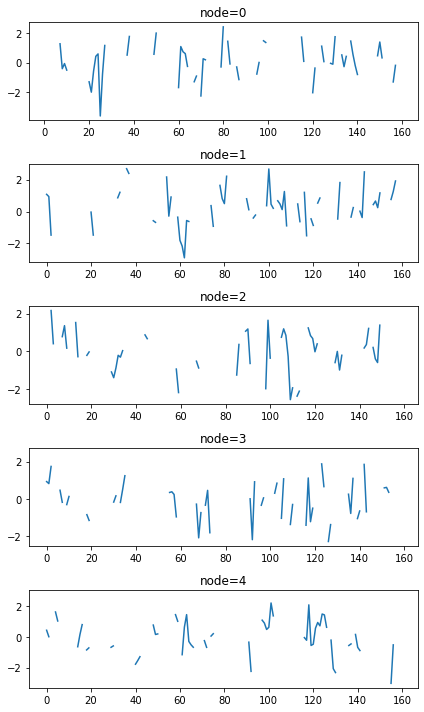

In [34]:
vis(fiveVTS_train);

# 1. Mean

In [35]:
fiveVTS_train_mean = fiveVTS_train.copy()

In [36]:
fiveVTS_train_mean[seed_number1,0] = np.nanmean(fiveVTS_train_mean[:,0])

In [37]:
fiveVTS_train_mean[seed_number2,1] = np.nanmean(fiveVTS_train_mean[:,1])

In [38]:
fiveVTS_train_mean[seed_number3,2] = np.nanmean(fiveVTS_train_mean[:,2])

In [39]:
fiveVTS_train_mean[seed_number4,3] = np.nanmean(fiveVTS_train_mean[:,3])

In [40]:
fiveVTS_train_mean[seed_number5,4] = np.nanmean(fiveVTS_train_mean[:,4])

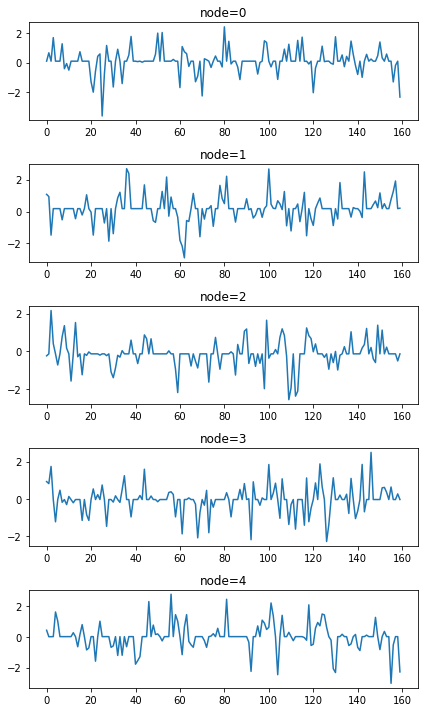

In [41]:
vis(fiveVTS_train_mean);

## 1) ST-GCN

In [42]:
mean_f_fiveVTS_train = torch.tensor(fiveVTS_train_mean).reshape(160,5,1).float()

In [43]:
mean_X_fiveVTS = mean_f_fiveVTS_train[:159,:,:]
mean_y_fiveVTS = mean_f_fiveVTS_train[1:,:,:]

In [44]:
model = RecurrentGCN(node_features=1, filters=4)

optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

model.train()

for epoch in tqdm(range(50)):
    for time, (xt,yt) in enumerate(zip(mean_X_fiveVTS,mean_y_fiveVTS)):
        y_hat = model(xt, edge_index, edge_attr)
        cost = torch.mean((y_hat-yt)**2)
        cost.backward()
        optimizer.step()
        optimizer.zero_grad()

100%|██████████| 50/50 [00:26<00:00,  1.87it/s]


In [51]:
mean_fhat_fiveVTS = torch.stack([model(xt, edge_index, edge_attr) for xt in mean_X_fiveVTS]).detach().numpy()

In [56]:
xt_test = torch.tensor(fiveVTS_test.reshape(40,5,1)[:-1,:,:]).float()

In [57]:
mean_fhat_fiveVTS_forecast = torch.stack([model(xt, edge_index, edge_attr) for xt in xt_test]).detach().numpy()

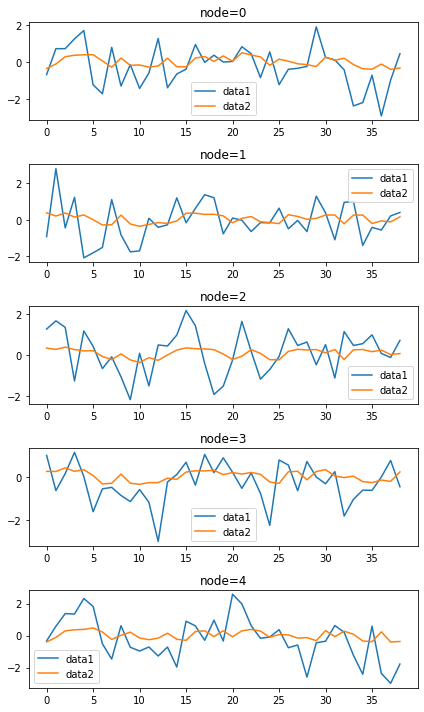

In [58]:
vis2(fiveVTS_test[1:],mean_fhat_fiveVTS_forecast);

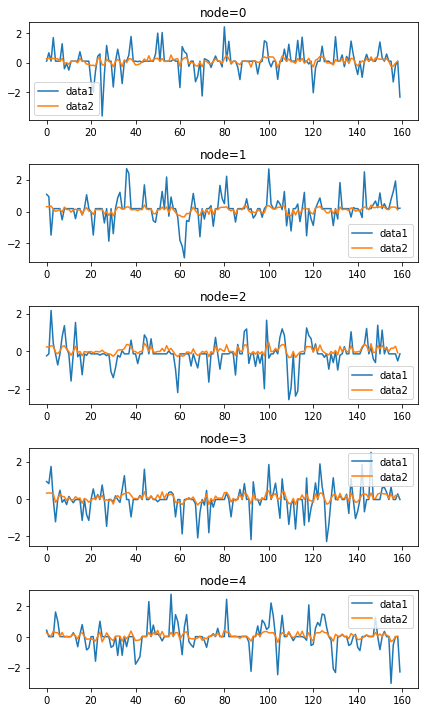

In [59]:
vis2(fiveVTS_train_mean,mean_fhat_fiveVTS);

## 2) Fourier transform

In [60]:
w=np.zeros((159*N,159*N))

In [61]:
for i in range(159*N):
    for j in range(159*N):
        if i==j :
            w[i,j] = 0
        elif np.abs(i-j) <= 1 : 
            w[i,j] = 1

In [60]:
# np.fft(mean_fhat_fiveVTS[:,0,0])

In [61]:
# mean_fhat_fiveVTS.shape

In [62]:
# fft_result =np.stack([np.fft.fft(mean_fhat_fiveVTS[:,n,0]) for n in range(N)]).T

In [63]:
# plt.plot(abs(fft_result[:,0])**2)

In [62]:
d = np.array(w.sum(axis=1))
D = np.diag(d)
L = np.array(np.diag(1/np.sqrt(d)) @ (D-w) @ np.diag(1/np.sqrt(d)))
lamb, Psi = np.linalg.eigh(L)
Lamb = np.diag(lamb)

In [63]:
fhatbar = Psi.T @ mean_fhat_fiveVTS.reshape(159*N,1)
power = fhatbar**2 

## 3) Ebayes

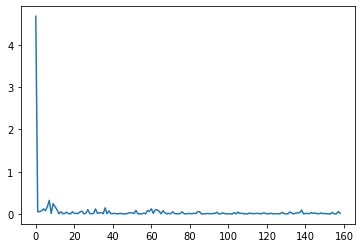

In [64]:
plt.plot(fhatbar.reshape(159,5)[:,0]**2)

In [67]:
ebayesthresh = importr('EbayesThresh').ebayesthresh
fhatbar_threshed = ebayesthresh(FloatVector(fhatbar))

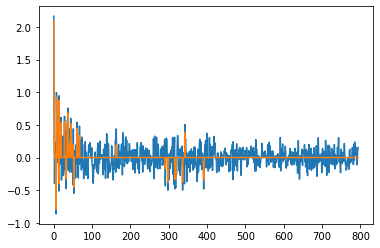

In [68]:
plt.plot(fhatbar)
plt.plot(fhatbar_threshed)

## 4) Inverse Fourier transform

In [71]:
fhatbarhat = Psi @ fhatbar_threshed
fhatbarhat_mean_spatio_temporal = fhatbarhat.reshape(159,N,1)

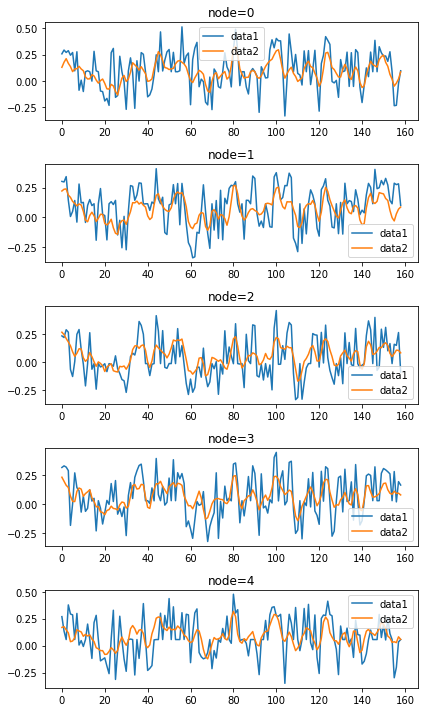

In [72]:
vis2(mean_fhat_fiveVTS,fhatbarhat_mean_spatio_temporal.reshape(159,5));

## 5) ST-GCN

In [73]:
mean_spatio_temporal = torch.tensor(fhatbarhat_mean_spatio_temporal).reshape(159,5,1).float()

In [74]:
mean_X_spatio_temporal = mean_spatio_temporal[:158,:,:]
mean_y_spatio_temporal = mean_spatio_temporal[1:,:,:]

In [75]:
model = RecurrentGCN(node_features=1, filters=4)

optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

model.train()

for epoch in tqdm(range(50)):
    for time, (xt,yt) in enumerate(zip(mean_X_spatio_temporal,mean_y_spatio_temporal)):
        y_hat = model(xt, edge_index, edge_attr)
        cost = torch.mean((y_hat-yt)**2)
        cost.backward()
        optimizer.step()
        optimizer.zero_grad()

100%|██████████| 50/50 [00:26<00:00,  1.91it/s]


In [95]:
mean_fhat_spatio_temporal = torch.stack([model(xt, edge_index, edge_attr) for xt in mean_X_spatio_temporal]).detach().numpy()

In [96]:
mean_fhat_spatio_temporal_test = torch.stack([model(xt, edge_index, edge_attr) for xt in xt_test]).detach().numpy()

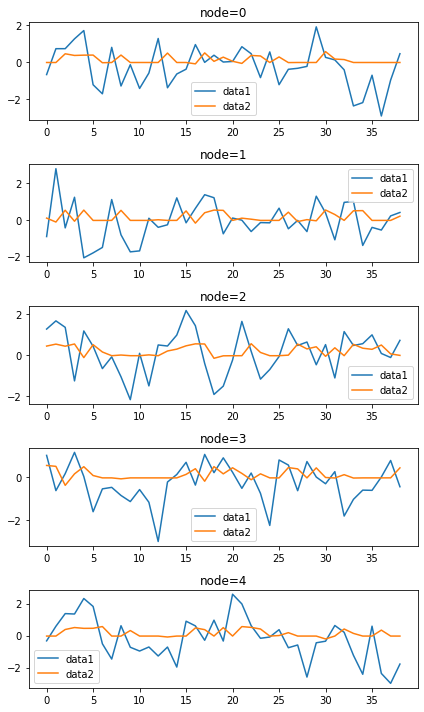

In [97]:
vis2(fiveVTS_test[1:],mean_fhat_spatio_temporal_test);

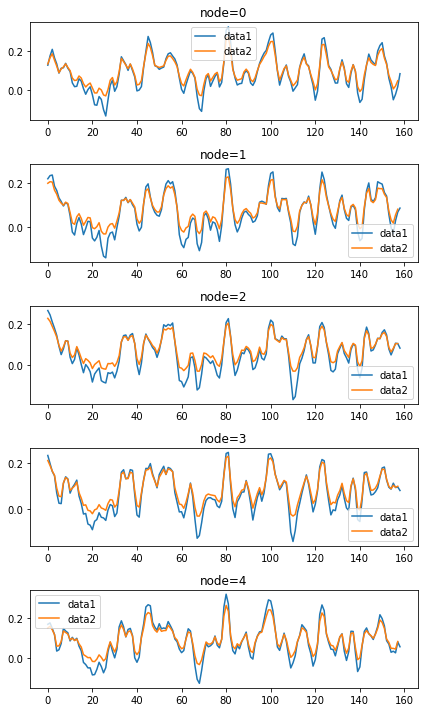

In [98]:
vis2(fhatbarhat_mean_spatio_temporal,mean_fhat_spatio_temporal);

## 6) Fourier transform

In [108]:
w=np.zeros((158*N,158*N))

In [109]:
for i in range(158*N):
    for j in range(158*N):
        if i==j :
            w[i,j] = 0
        elif np.abs(i-j) <= 1 : 
            w[i,j] = 1

In [110]:
d = np.array(w.sum(axis=1))
D = np.diag(d)
L = np.array(np.diag(1/np.sqrt(d)) @ (D-w) @ np.diag(1/np.sqrt(d)))
lamb, Psi = np.linalg.eigh(L)
Lamb = np.diag(lamb)

In [112]:
fhatbar = Psi.T @ mean_fhat_spatio_temporal.reshape(158*N,1)
power = fhatbar**2 

## 7) Ebayes

In [113]:
ebayesthresh = importr('EbayesThresh').ebayesthresh
fhatbar_threshed = ebayesthresh(FloatVector(fhatbar))

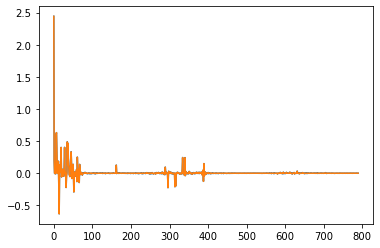

In [114]:
plt.plot(fhatbar)
plt.plot(fhatbar_threshed)

## 8) Inverse Fourier transform

In [121]:
fhatbarhat = Psi @ fhatbar_threshed
fhatbarhat_mean_spatio_temporal2 = fhatbarhat.reshape(158,N,1)

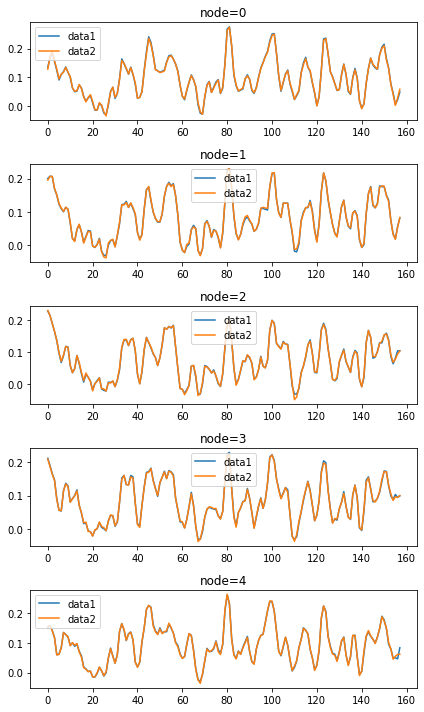

In [122]:
vis2(mean_fhat_spatio_temporal,fhatbarhat_mean_spatio_temporal2.reshape(158,5));

## 9) ST-GCN

In [124]:
mean_spatio_temporal2 = torch.tensor(fhatbarhat_mean_spatio_temporal2).reshape(158,5,1).float()

In [125]:
mean_X_spatio_temporal2 = mean_spatio_temporal2[:157,:,:]
mean_y_spatio_temporal2 = mean_spatio_temporal2[1:,:,:]

In [126]:
model = RecurrentGCN(node_features=1, filters=4)

optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

model.train()

for epoch in tqdm(range(50)):
    for time, (xt,yt) in enumerate(zip(mean_X_spatio_temporal2,mean_y_spatio_temporal2)):
        y_hat = model(xt, edge_index, edge_attr)
        cost = torch.mean((y_hat-yt)**2)
        cost.backward()
        optimizer.step()
        optimizer.zero_grad()

100%|██████████| 50/50 [00:26<00:00,  1.89it/s]


In [127]:
mean_fhat_spatio_temporal2 = torch.stack([model(xt, edge_index, edge_attr) for xt in mean_X_spatio_temporal2]).detach().numpy()

In [128]:
mean_fhat_spatio_temporal_test2 = torch.stack([model(xt, edge_index, edge_attr) for xt in xt_test]).detach().numpy()

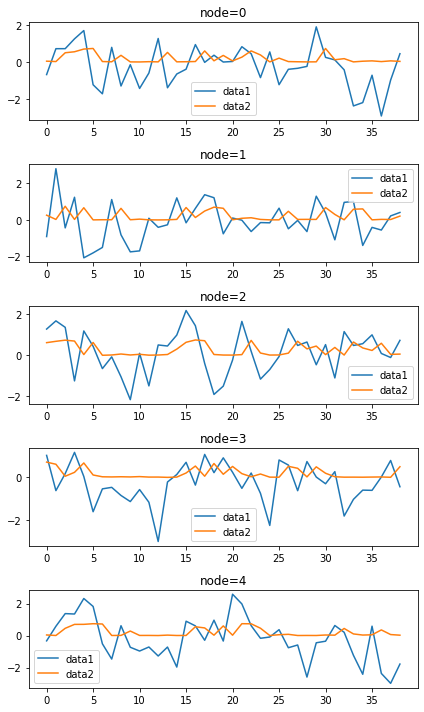

In [129]:
vis2(fiveVTS_test[1:],mean_fhat_spatio_temporal_test2);

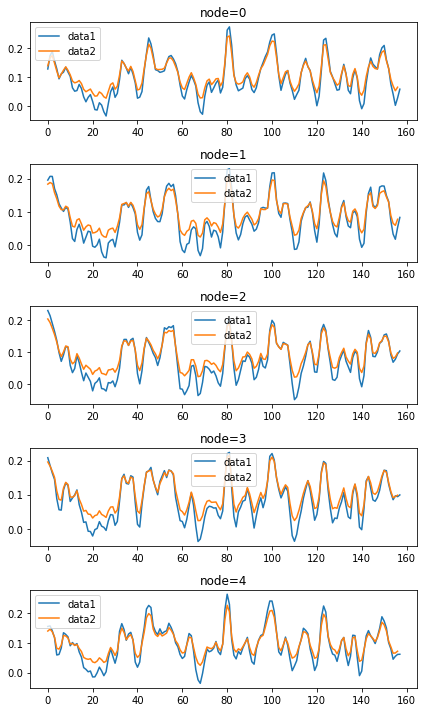

In [130]:
vis2(fhatbarhat_mean_spatio_temporal2,mean_fhat_spatio_temporal2);

# 2. Linear Interpolation

In [ ]:
_df = pd.DataFrame(fiveVTS_train)
_df.interpolate(method='linear', inplace=True)
_df = _df.fillna(0)

In [ ]:
linear_fiveVTS_train = np.array(_df).reshape(160,5)

## 1) ST-GCN

In [ ]:
linear_f_fiveVTS_train = torch.tensor(linear_fiveVTS_train).reshape(160,5,1).float()

In [ ]:
linear_X_fiveVTS = linear_f_fiveVTS_train[:159,:,:]
linear_y_fiveVTS = linear_f_fiveVTS_train[1:,:,:]

In [ ]:
model = RecurrentGCN(node_features=1, filters=4)

optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

model.train()

for epoch in tqdm(range(50)):
    for time, (xt,yt) in enumerate(zip(linear_X_fiveVTS,linear_y_fiveVTS)):
        y_hat = model(xt, edge_index, edge_attr)
        cost = torch.mean((y_hat-yt)**2)
        cost.backward()
        optimizer.step()
        optimizer.zero_grad()

In [ ]:
linear_fhat_fiveVTS = torch.stack([model(xt, edge_index, edge_attr) for xt in linear_X_fiveVTS]).detach().numpy()

## 2) Fourier transform

In [ ]:
w=np.zeros((159*N,159*N))

In [ ]:
for i in range(159*N):
    for j in range(159*N):
        if i==j :
            w[i,j] = 0
        elif np.abs(i-j) <= 1 : 
            w[i,j] = 1

In [ ]:
d = np.array(w.sum(axis=1))
D = np.diag(d)
L = np.array(np.diag(1/np.sqrt(d)) @ (D-w) @ np.diag(1/np.sqrt(d)))
lamb, Psi = np.linalg.eigh(L)
Lamb = np.diag(lamb)
fhatbar = Psi @ linear_fhat_fiveVTS.reshape(159*N,1)
power = fhatbar**2 

## 3) Ebayes

In [ ]:
ebayesthresh = importr('EbayesThresh').ebayesthresh
power_threshed=np.array([np.array(ebayesthresh(FloatVector(fhatbar[i]**2))) for i in range(159*N)])
fhatbar_threshed = np.where(power_threshed>0,fhatbar,0)

## 4) Inverse Fourier transform

In [ ]:
fhatbarhat = Psi @ fhatbar_threshed
fhatbarhat_linear_spatio_temporal = fhatbarhat.reshape(159,N,1)

## 5) ST-GCN

In [ ]:
linear_spatio_temporal = torch.tensor(fhatbarhat_linear_spatio_temporal).reshape(159,5,1).float()

In [ ]:
linear_X_spatio_temporal = linear_spatio_temporal[:158,:,:]
linear_y_spatio_temporal = linear_spatio_temporal[1:,:,:]

In [ ]:
model = RecurrentGCN(node_features=1, filters=4)

optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

model.train()

for epoch in tqdm(range(50)):
    for time, (xt,yt) in enumerate(zip(linear_X_spatio_temporal,linear_y_spatio_temporal)):
        y_hat = model(xt, edge_index, edge_attr)
        cost = torch.mean((y_hat-yt)**2)
        cost.backward()
        optimizer.step()
        optimizer.zero_grad()

---

In [ ]:
linear_X_spatio_temporal_fore = linear_spatio_temporal[119:,:,:]

In [ ]:
linear_fhat_spatio_temporal = torch.stack([model(xt, edge_index, edge_attr) for xt in linear_X_spatio_temporal_fore]).detach().numpy()

### Box plot

In [ ]:
plt.figure(figsize=(20, 8))
plt.boxplot((linear_fhat_spatio_temporal.reshape(40,5) -  fiveVTS_test))

In [ ]:
plt.figure(figsize=(20, 8))
plt.boxplot(((linear_fhat_spatio_temporal.reshape(40,5) -  fiveVTS_test)).reshape(200,1))

## 6) Fourier transform

In [ ]:
linear_fhat_spatio_temporal = torch.stack([model(xt, edge_index, edge_attr) for xt in linear_spatio_temporal]).detach().numpy()

In [ ]:
w=np.zeros((159*N,159*N))

In [ ]:
for i in range(159*N):
    for j in range(159*N):
        if i==j :
            w[i,j] = 0
        elif np.abs(i-j) <= 1 : 
            w[i,j] = 1

In [ ]:
d = np.array(w.sum(axis=1))
D = np.diag(d)
L = np.array(np.diag(1/np.sqrt(d)) @ (D-w) @ np.diag(1/np.sqrt(d)))
lamb, Psi = np.linalg.eigh(L)
Lamb = np.diag(lamb)
fhatbar = Psi @ linear_fhat_fiveVTS.reshape(159*N,1)
power = fhatbar**2 

## 7) Ebayes

In [ ]:
ebayesthresh = importr('EbayesThresh').ebayesthresh
power_threshed=np.array([np.array(ebayesthresh(FloatVector(fhatbar[i]**2))) for i in range(159*N)])
fhatbar_threshed = np.where(power_threshed>0,fhatbar,0)

## 8) Inverse Fourier transform

In [ ]:
fhatbarhat = Psi @ fhatbar_threshed
fhatbarhat_linear_spatio_temporal = fhatbarhat.reshape(159,N,1)

## 9) ST-GCN

In [ ]:
linear_spatio_temporal2 = torch.tensor(fhatbarhat_linear_spatio_temporal).reshape(159,5,1).float()

In [ ]:
linear_X_spatio_temporal2 = linear_spatio_temporal2[:158,:,:]
linear_y_spatio_temporal2 = linear_spatio_temporal2[1:,:,:]

In [ ]:
model = RecurrentGCN(node_features=1, filters=4)

optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

model.train()

for epoch in tqdm(range(50)):
    for time, (xt,yt) in enumerate(zip(linear_X_spatio_temporal2,linear_y_spatio_temporal2)):
        y_hat = model(xt, edge_index, edge_attr)
        cost = torch.mean((y_hat-yt)**2)
        cost.backward()
        optimizer.step()
        optimizer.zero_grad()

In [ ]:
linear_X_spatio_temporal_fore2 = linear_spatio_temporal2[119:,:,:]

In [ ]:
linear_fhat_spatio_temporal2 = torch.stack([model(xt, edge_index, edge_attr) for xt in linear_X_spatio_temporal_fore2]).detach().numpy()

### Box plot

In [ ]:
plt.figure(figsize=(20, 8))
plt.boxplot((linear_fhat_spatio_temporal2.reshape(40,5) -  fiveVTS_test))

In [ ]:
plt.figure(figsize=(20, 8))
plt.boxplot(((linear_fhat_spatio_temporal2.reshape(40,5) -  fiveVTS_test)).reshape(200,1))

# 3. GNAR

**mean**

In [ ]:
%R -i fiveVTS_train_mean

In [ ]:
%%R
meanprediction <- predict(GNARfit(vts = fiveVTS_train_mean[1:160,], net = fiveNet, alphaOrder = 2, betaOrder = c(1, 1)),n.ahead=40)

In [ ]:
%R -o meanprediction

In [ ]:
sum((meanprediction.reshape(40,5)[1] -  fiveVTS_test[1])**2)

In [ ]:
plt.figure(figsize=(20, 8))
plt.boxplot((meanprediction.reshape(40,5) -  fiveVTS_test))

In [ ]:
plt.figure(figsize=(20, 8))
plt.boxplot(((meanprediction.reshape(40,5) -  fiveVTS_test)).reshape(200,1))